# AI Recomender Project

In [2]:
import numpy as np
import pandas as pd
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse import lil_matrix
import copy
from sklearn.model_selection import train_test_split
tqdm.pandas() #for progres_apply etc.

In [2]:
#read file line-by-line and parse json, returns dataframe
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df


# 1. Load Goodreads data

In [3]:
goodreads_path = './'
books = 'goodreads_books_comics_graphic.json.gz'
interactions = 'goodreads_interactions_comics_graphic.json.gz'
reviews = 'goodreads_reviews_comics_graphic.json.gz'

# 2. Clean data
Example of:
- Merging two files
- tqdm pd.progress_apply
- Example of non-destructive transforms, i.e. keep original data and make re-running cell works
- Parsing dates

In [4]:
#books
books_df = pd.read_json(goodreads_path + books, lines=True)
books_df = books_df[['book_id',	'title','authors',	'publisher',	'num_pages',	'publication_year']]
display(books_df.head(5))

,book_id,title,authors,publisher,num_pages,publication_year
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997


In [5]:
#get author names (authors metadata is an additional dowload from goodreads)
authors = 'goodreads_book_authors.json.gz'
authors_df =  pd.read_json(goodreads_path + authors, lines=True) #829.529 authors (also non-graphic and comics)
display(authors_df.head(5))

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


In [6]:
#merge, but inline for each row, since each book has many authors
author_id_to_name = {}
for idx, row in tqdm(authors_df.iterrows(), total=authors_df.shape[0]):
  author_id_to_name[row['author_id']] = row['name']
display(books_df.head(5))
#important: type of author is np.int64
books_df['author_name'] = books_df['authors'].apply(lambda authors_dct_lst: author_id_to_name.get(np.int64(authors_dct_lst[0]['author_id'])))
display(books_df.head(5))

100%|██████████| 829529/829529 [00:58<00:00, 14082.84it/s]


,book_id,title,authors,publisher,num_pages,publication_year
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997


,book_id,title,authors,publisher,num_pages,publication_year,author_name
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,,Lindsey Schussman
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016,Florence Dupre la Tour
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012,Ed Brubaker
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,,Jason Delgado
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997,Jerry Siegel


In [7]:
#interactions
#wc -l interactions is 7.347.630 
#sample first 500.000 interactions
interactions_df = parse_json(goodreads_path + interactions, read_max=500000) #Note: RAM issue if loading with pd.read_json, no issue with parse_json 

500000it [00:24, 20239.04it/s]


Break reading after 500000 records
Reading 500001 rows.


In [8]:
#1) parse date 
interactions_df_new = interactions_df[['user_id', 'book_id', 'rating', 'date_updated']]
format_str = '%a %b %d %H:%M:%S %z %Y' #see https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
#test: datetime_object = datetime.strptime('Fri Jun 21 10:25:05 -0700 2013', format_str) 
interactions_df_new['date_updated'] = interactions_df_new['date_updated'].progress_apply(lambda s: np.datetime64(datetime.strptime(s,format_str)))

#2) sort on user_id, then date
interactions_df_new = interactions_df_new.sort_values(by=['user_id', 'date_updated'], ascending=[True,True])
display(interactions_df_new.head(20))

  0%|          | 0/500001 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """
100%|██████████| 500001/500001 [00:18<00:00, 27133.38it/s]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,user_id,book_id,rating,date_updated
496200,00153d136ac254437511fad5e10e246d,7619292,3,2012-08-30 18:53:39
496199,00153d136ac254437511fad5e10e246d,29396738,0,2017-08-07 10:40:09
350064,0018ce6296baeccf95c3502deeff0600,472331,5,2012-08-05 16:26:00
350062,0018ce6296baeccf95c3502deeff0600,3058907,4,2012-08-05 20:11:48
350061,0018ce6296baeccf95c3502deeff0600,4280231,4,2012-08-05 20:11:52
350059,0018ce6296baeccf95c3502deeff0600,11470711,5,2012-08-05 20:14:57
350058,0018ce6296baeccf95c3502deeff0600,844355,4,2012-08-05 20:19:32
350057,0018ce6296baeccf95c3502deeff0600,1568491,4,2012-08-05 20:19:39
350056,0018ce6296baeccf95c3502deeff0600,23754,4,2012-08-09 10:53:26
350063,0018ce6296baeccf95c3502deeff0600,13480845,5,2012-08-15 11:26:40


# 3. Preprocessing

In [9]:
def preprocess_classic(df, minsup=5):
    """
    Goal: - Remove reconsumption items
          - Remove items that have less than minsup interactions 
          - Remove users that have less than minsup interactions 
               
    :input df: Dataframe containing user_id, item_id and time
    """
    before = df.shape[0]
    #drop reconsumption items
    df = df.drop_duplicates(subset=["user_id","item_id"])
    print("After drop_duplicates (reconsumption items): {} -> {}".format(before,df.shape[0]))
    #compute item/user counts
    g1 = df.groupby('item_id', as_index=False)['user_id'].size()
    g1 = g1.rename({'size': 'count_item'}, axis='columns')
    g2 = df.groupby('user_id', as_index=False)['item_id'].size()
    g2 = g2.rename({'size': 'count_user'}, axis='columns')
    df = pd.merge(df, g1, how='left', on=['item_id'])
    df = pd.merge(df, g2, how='left', on=['user_id'])
    display(df.head(5))
    #drop items occurring less than minsup times
    before = df.shape[0]
    df = df[df['count_item'] >= minsup]
    print("After dropping items with less than {} interactions: {} -> {}".format(minsup, before,df.shape[0]))
    before = df.shape[0]
    #drop users with less then minsup items in history
    df = df[df['count_user'] >= minsup]
    df = df[['user_id','item_id','datetime']]
    print("After dropping users with less than {} interactions: {} -> {}".format(minsup, before,df.shape[0]))
    return df

# just rating >= 3
print(f"number of unique users: {interactions_df_new['user_id'].nunique()}")
print(f"number of unique items: {interactions_df_new['book_id'].nunique()}")
interactions_df_new = interactions_df_new[interactions_df_new["rating"] >= 3]
print(f"number of unique users after rating < 3 removal: {interactions_df_new['user_id'].nunique()}")
print(f"number of unique items after rating < 3 removal: {interactions_df_new['book_id'].nunique()}")

#print number of users and items
interactions_df_processed = interactions_df_new[['user_id','book_id','date_updated']]
interactions_df_processed = interactions_df_processed.rename(columns={"user_id": "user_id", "book_id": "item_id", "date_updated": "datetime"})
print(f"number of unique users: {interactions_df_processed['user_id'].nunique()}")
print(f"number of unique items: {interactions_df_processed['item_id'].nunique()}")
interactions_df_processed = preprocess_classic(interactions_df_processed)
interactions_df_processed.reset_index(drop=True, inplace=True)
display(interactions_df_processed.head(5))
print(f"number of unique users: {interactions_df_processed['user_id'].nunique()}")
print(f"number of unique items: {interactions_df_processed['item_id'].nunique()}")
interactions_df_processed.sort_values(by=['datetime'], inplace=True)
print("Sorting by date")
interactions_df_processed.reset_index(inplace=True, drop=True)
display(interactions_df_processed.head(5))
column = interactions_df_processed["datetime"]
print(f"Max date is {column.max()}, min is {column.min()} ")

number of unique users: 18246
number of unique items: 53635
number of unique users after rating < 3 removal: 13358
number of unique items after rating < 3 removal: 44047
number of unique users: 13358
number of unique items: 44047
After drop_duplicates (reconsumption items): 294141 -> 294141


,user_id,item_id,datetime,count_item,count_user
0,00153d136ac254437511fad5e10e246d,7619292,2012-08-30 18:53:39,166,1
1,0018ce6296baeccf95c3502deeff0600,472331,2012-08-05 16:26:00,2015,12
2,0018ce6296baeccf95c3502deeff0600,3058907,2012-08-05 20:11:48,29,12
3,0018ce6296baeccf95c3502deeff0600,4280231,2012-08-05 20:11:52,27,12
4,0018ce6296baeccf95c3502deeff0600,11470711,2012-08-05 20:14:57,9,12


After dropping items with less than 5 interactions: 294141 -> 237677
After dropping users with less than 5 interactions: 237677 -> 226244


,user_id,item_id,datetime
0,0018ce6296baeccf95c3502deeff0600,472331,2012-08-05 16:26:00
1,0018ce6296baeccf95c3502deeff0600,3058907,2012-08-05 20:11:48
2,0018ce6296baeccf95c3502deeff0600,4280231,2012-08-05 20:11:52
3,0018ce6296baeccf95c3502deeff0600,11470711,2012-08-05 20:14:57
4,0018ce6296baeccf95c3502deeff0600,844355,2012-08-05 20:19:32


number of unique users: 6186
number of unique items: 11315
Sorting by date


,user_id,item_id,datetime
0,6050e06582f160ebca4c3dd4622d0a60,9517,2007-02-26 19:55:59
1,6050e06582f160ebca4c3dd4622d0a60,9516,2007-02-26 19:56:05
2,6050e06582f160ebca4c3dd4622d0a60,146160,2007-02-27 19:44:09
3,ece1ea5c02078b01f596a6630db66ae7,77173,2007-04-01 21:52:43
4,ece1ea5c02078b01f596a6630db66ae7,237559,2007-04-07 05:42:52


Max date is 2017-11-03 13:01:10, min is 2007-02-26 19:55:59 


# 4. Create consecutive ID's
- Working with numpy types != python types
- Mapping ID's to consecutive integgers for matrix operations (and scipy sparse matrices, see https://docs.scipy.org/doc/scipy/reference/sparse.html) 

In [10]:
#change type book_id to numpy.int64
display(interactions_df_processed.dtypes)
interactions_df_processed['item_id'] = interactions_df_processed['item_id'].astype('int64')
display(interactions_df_processed.dtypes)

user_id             object
item_id             object
datetime    datetime64[ns]
dtype: object

user_id             object
item_id              int64
datetime    datetime64[ns]
dtype: object

In [11]:
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id

#1) convert user uuid to consecutive integer ID's 
interactions_df_processed['user_id_int'] = interactions_df_processed['user_id'].progress_apply(map_to_consecutive_id)

#2) convert book_id to to consecutive integer ID's 
dct.clear()
interactions_df_processed['item_id_int'] = interactions_df_processed['item_id'].progress_apply(map_to_consecutive_id)
display(interactions_df_processed.head(10))

column = interactions_df_processed['item_id_int'] 
max_item_id = column.max()

column = interactions_df_processed['user_id_int'] 
max_user_id = column.max()

100%|██████████| 226244/226244 [00:00<00:00, 593839.99it/s]


,user_id,item_id,datetime,user_id_int,item_id_int
0,6050e06582f160ebca4c3dd4622d0a60,9517,2007-02-26 19:55:59,0,0
1,6050e06582f160ebca4c3dd4622d0a60,9516,2007-02-26 19:56:05,0,1
2,6050e06582f160ebca4c3dd4622d0a60,146160,2007-02-27 19:44:09,0,2
3,ece1ea5c02078b01f596a6630db66ae7,77173,2007-04-01 21:52:43,1,3
4,ece1ea5c02078b01f596a6630db66ae7,237559,2007-04-07 05:42:52,1,4
5,d4b1dcb35db677f20ee45225a5e43be2,38990,2007-05-26 21:35:54,2,5
6,d9ebeabca4551266567e061294d6dd5e,135642,2007-05-27 16:08:12,3,6
7,a6d2293f4d6542e2edb335eab2daad39,124817,2007-05-28 05:19:46,4,7
8,a6d2293f4d6542e2edb335eab2daad39,77281,2007-05-28 05:20:38,4,8
9,a6d2293f4d6542e2edb335eab2daad39,109648,2007-05-28 05:20:41,4,9


In [12]:
df = interactions_df_processed[['user_id_int', 'item_id_int', 'datetime', 'user_id']].copy().rename(columns={"user_id_int": "user_id", "item_id_int": "item_id", "datetime": "datetime", "user_id": 'old_id'})
display(df)

print(f"Max user_id is {max_user_id}, Max item_id is {max_item_id}")

,user_id,item_id,datetime,old_id
0,0,0,2007-02-26 19:55:59,6050e06582f160ebca4c3dd4622d0a60
1,0,1,2007-02-26 19:56:05,6050e06582f160ebca4c3dd4622d0a60
2,0,2,2007-02-27 19:44:09,6050e06582f160ebca4c3dd4622d0a60
3,1,3,2007-04-01 21:52:43,ece1ea5c02078b01f596a6630db66ae7
4,1,4,2007-04-07 05:42:52,ece1ea5c02078b01f596a6630db66ae7
...,...,...,...,...
226239,1574,1327,2017-11-02 05:04:13,538040d2635575cb019fc0bcf0fb30bf
226240,5666,1039,2017-11-02 05:42:50,55acdcf9e6db1867ce5c674809a467d6
226241,6104,4509,2017-11-02 21:23:58,b9fdf777f128d5597b56226c451ea40f
226242,6104,8343,2017-11-02 21:25:28,b9fdf777f128d5597b56226c451ea40f


Max user_id is 6185, Max item_id is 11314


In [13]:
# splitting
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# rebuilding user_id
dct.clear()

train['user_id'] = train['user_id'].progress_apply(map_to_consecutive_id)

dct.clear()

test['user_id'] = test['user_id'].progress_apply(map_to_consecutive_id)

dct.clear()

def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user_id')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

test_tr, test_te = split_train_test_proportion(test)

display(train)
display(test_tr)
display(test_te)

100%|██████████| 45249/45249 [00:00<00:00, 570937.12it/s]

0 users sampled


1000 users sampled
2000 users sampled
3000 users sampled


,user_id,item_id,datetime,old_id
0,0,0,2007-02-26 19:55:59,6050e06582f160ebca4c3dd4622d0a60
1,0,1,2007-02-26 19:56:05,6050e06582f160ebca4c3dd4622d0a60
2,0,2,2007-02-27 19:44:09,6050e06582f160ebca4c3dd4622d0a60
3,1,3,2007-04-01 21:52:43,ece1ea5c02078b01f596a6630db66ae7
4,1,4,2007-04-07 05:42:52,ece1ea5c02078b01f596a6630db66ae7
...,...,...,...,...
180990,5582,707,2016-05-10 18:07:36,56ae4d4f64791c5b3a4c7d40d89b9d0c
180991,5582,3627,2016-05-10 18:07:36,56ae4d4f64791c5b3a4c7d40d89b9d0c
180992,5582,8548,2016-05-10 18:09:47,56ae4d4f64791c5b3a4c7d40d89b9d0c
180993,5582,4867,2016-05-10 18:09:48,56ae4d4f64791c5b3a4c7d40d89b9d0c


,user_id,item_id,datetime,old_id
189828,0,10071,2016-08-20 17:50:57,56ae4d4f64791c5b3a4c7d40d89b9d0c
189829,0,8195,2016-08-20 17:51:08,56ae4d4f64791c5b3a4c7d40d89b9d0c
189830,0,8693,2016-08-20 17:51:39,56ae4d4f64791c5b3a4c7d40d89b9d0c
189831,0,729,2016-08-20 17:55:02,56ae4d4f64791c5b3a4c7d40d89b9d0c
189832,0,6086,2016-08-20 17:55:27,56ae4d4f64791c5b3a4c7d40d89b9d0c
...,...,...,...,...
225782,3308,11305,2017-10-26 05:54:11,8a79d0ed286d58193cb9bdc8498df6d9
225802,3309,9843,2017-10-26 06:13:58,6a1acafcd50a650552cf2172492e4c24
225827,3309,9844,2017-10-26 06:30:32,6a1acafcd50a650552cf2172492e4c24
225943,3310,9851,2017-10-26 11:51:19,99719771853aea962e92929366418cd9


,user_id,item_id,datetime,old_id
180995,0,4871,2016-05-10 18:09:48,56ae4d4f64791c5b3a4c7d40d89b9d0c
180996,0,4368,2016-05-10 18:11:38,56ae4d4f64791c5b3a4c7d40d89b9d0c
189834,0,389,2016-08-20 17:56:00,56ae4d4f64791c5b3a4c7d40d89b9d0c
189836,0,1873,2016-08-20 17:56:37,56ae4d4f64791c5b3a4c7d40d89b9d0c
189839,0,7013,2016-08-20 17:57:06,56ae4d4f64791c5b3a4c7d40d89b9d0c
...,...,...,...,...
225917,3280,9849,2017-10-26 11:13:11,e74017084456efaeff91c8ad979fbf2e
225603,3281,9846,2017-10-25 06:35:00,389089cfb7e93715b1871da42567b20b
225875,3281,11307,2017-10-26 10:14:05,389089cfb7e93715b1871da42567b20b
226011,3281,11308,2017-10-26 15:03:03,389089cfb7e93715b1871da42567b20b


In [14]:
test_tr.to_csv(os.path.join("./", 'test_tr.csv'), index=False)
test_te.to_csv(os.path.join("./", 'test_te.csv'), index=False)
train.to_csv(os.path.join("./", 'train.csv'), index=False)


In [15]:
# computing X
X = np.zeros((train["user_id"].max()+1, max_item_id+1), dtype=np.bool_)

for _, row in train.iterrows():
    X[row['user_id'], row['item_id']] = 1

X = csr_matrix(X, dtype=np.int64)

sparse.save_npz("X.npz", X)

X_test = np.zeros((test_tr["user_id"].max()+1, max_item_id+1), dtype=np.bool_)

for _, row in test_tr.iterrows():
    X_test[row['user_id'], row['item_id']] = 1

X_test = csr_matrix(X_test, dtype=np.int64)

sparse.save_npz("X_test.npz", X_test)


# 5. Negative interaction

In [16]:
X = sparse.load_npz("X.npz")
X_test = sparse.load_npz("X_test.npz")
test_te = pd.read_csv("test_te.csv")
test_tr = pd.read_csv("test_tr.csv")

X_transpose = csr_matrix(X.T, dtype=np.float64)
X = csr_matrix(X, dtype=np.float64)
print(X.shape)
print(X_test.shape)
print(X_transpose.shape)
print(X.nnz)

(5874, 11315)
(3311, 11315)
(11315, 5874)
180995


In [ ]:
# identifyig valuable pairs
XtX = X_transpose @ X
XtXdiag = XtX.diagonal()
XtX = XtX.tolil()
XtX[np.tril_indices(XtX.shape[0], k=0)] = 0.0
XtX = XtX.tocsr()
print("Check: ", np.all(XtX[np.tril_indices(XtX.shape[0], k=0)] == 0.0))
print(XtX.shape)

t = 40
pair_list = np.argwhere(XtX.toarray() > t)

# rebuild XtX
XtX = X_transpose @ X

pair_list = np.array(pair_list, dtype=np.int32)
print(pair_list.shape)

np.save("pair_list.npy", pair_list)

In [ ]:
# computing M
def compute_M(X):
    M = lil_matrix((len(pair_list), X.shape[1]), dtype=np.int64)

    for x in range(len(pair_list)):
        M[x, pair_list[x, 0]] = 1
        M[x, pair_list[x, 1]] = 1

    M = csr_matrix(M)
    return M

M = compute_M(X)
print(M.shape)

In [ ]:
# computing Z
Z = X @ M.transpose()

# non linear function f
Z = (Z == 2.0 )

# back to float 64 from np.bool_
Z = Z * 1.0

# computing Z_test 
Z_test = X_test @ compute_M(X_test).transpose()
Z_test = (Z_test == 2.0 )
Z_test = Z_test * 1.0

print(Z.shape)
print(Z.nnz)
print(Z.dtype)
print(Z_test.shape)
print(Z_test.nnz)
print(Z_test.dtype)

sparse.save_npz("Z.npz", Z)
sparse.save_npz("X_test.npz", X_test)
sparse.save_npz("Z_test.npz", Z_test)

In [ ]:
X = X * 1.0
Zt = Z.T
Zt.indptr = Zt.indptr.astype(np.uint64)
Zt.indices = Zt.indices.astype(np.uint64)
ZtZ = Zt.dot(Z)
ZtX = Zt.dot(X)
ZtZdiag=copy.deepcopy(ZtZ.diagonal())
print(ZtZ.shape)
print(ZtX.shape)
print(XtX.shape)

In [ ]:
lambdaBB, lambdaCC, rho = 500,  5000, 1000
ZtX = ZtX.todense()
print(ZtX.dtype)
print(XtX.dtype)
print(ZtZ.dtype)

In [ ]:
# precompute for BB
ii_diag = np.diag_indices(XtX.shape[0], ndim=2)
XtX = XtX.todense()
XtX[ii_diag] = XtXdiag+lambdaBB
PP = np.linalg.inv(XtX)
PP = np.array(PP)


In [ ]:
# precompute for CC
ii_diag_ZZ=np.diag_indices(ZtZ.shape[0], ndim=2)
ZtZ = ZtZ.todense()
ZtZ[ii_diag_ZZ] = ZtZdiag+lambdaCC+rho
QQ = np.linalg.inv(ZtZ)
QQ = np.array(QQ)


In [ ]:
epochs = 40

 # initialize
CCmask = M.nonzero()
CC = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float64 )
temp = CC.copy()
DD = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float64 )
UU = np.zeros( (ZtZ.shape[0], XtX.shape[0]),dtype=np.float64 ) # is Gamma in paper
for iter in range(epochs):
    print("epoch {}".format(iter))
    # learn BB
    XtX[ii_diag] = XtXdiag
    BB = PP.dot(XtX-ZtX.T.dot(CC))
    gamma = np.diag(BB) / np.diag(PP)
    BB -= PP * gamma
    # learn CC
    CC = QQ.dot(ZtX-ZtX.dot(BB) +rho *(DD-UU))
    # learn DD
    temp = CC.copy()
    temp[CCmask] = 0.0
    DD = temp
    #DD= np.maximum(0.0, DD) # if you want to enforce non-negative parameters
    # learn UU (is Gamma in paper)
    UU += CC-DD

In [ ]:
np.save("./CC.npy", CC)
np.save("./BB.npy", BB)

# 6. Evaluate quantitatively
Options are:
- **Hitrate@k**, i.e. percentage of users where top-$k$ recommendations is relevant 
- **Recall@k**, i.e. percentage of top-$k$ recommendation that are relevant
- **NDCG@k**, i.e. like recall but rank of top-$k$ recommendation is weighted

Compare using relative gain, i.e. recall@10 from 10% tot 20% is a 100% gain (20-10/10 * 100) 

In [4]:
path = "./Test_esame/Test4/"
BB = np.load(path + "BB.npy")
CC = np.load(path + "CC.npy")
X_test = sparse.load_npz(path + "X_test.npz")
Z_test = sparse.load_npz(path + "Z_test.npz")

print(BB.shape)
print(CC.shape)
print(X_test.shape)
print(Z_test.shape)
print(X_test.nnz)
print(Z_test.nnz)
test_te = pd.read_csv(path + "test_te.csv")
test_te = test_te[['user_id', 'book_id']]

(15175, 15175)
(11522, 15175)
(1634, 15175)
(1634, 11522)
63579
135872


In [5]:
#pred_val = (X_test).dot(BB) + Z_test.dot(CC)
pred_val = (X_test @ BB) + (Z_test @ CC)

In [6]:
pred_val[X_test.nonzero()] = -np.inf # exclude examples from training and validation (if any)

In [7]:
print(pred_val.shape)
print(pred_val.nonzero()[0].shape)

(1634, 15175)
(24795950,)


In [8]:
test_matrix = np.zeros_like(pred_val, dtype=bool)

for _, row in test_te.iterrows():
    test_matrix[row['user_id'], row['book_id']] = 1

print(test_matrix.nonzero()[0].shape)

(15085,)


In [9]:
def Recall_at_k(X_pred, test_mat, k):

    idx = np.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    for x in range(X_pred_binary.shape[0]):
        X_pred_binary[x, idx[x, :k]] = True

    X_true_binary = (test_mat > 0)
    tmp = (np.logical_and(X_true_binary, X_pred_binary)).astype(np.float64)

    den = np.minimum(k, X_true_binary.sum(axis=1)).astype(np.float64)

    if not np.all(tmp.sum(axis=1)<=k) and not np.all(tmp.sum(axis=1)>=0):
        print("error in k = ", k)

    recall = tmp.sum(axis=1) / den

    recall = np.nan_to_num(recall, nan=0.0)
    return recall


r3 = (Recall_at_k(pred_val, test_matrix, k=3))
r5 = (Recall_at_k(pred_val, test_matrix, k=5))
r10 = (Recall_at_k(pred_val, test_matrix, k=10))
r20 = (Recall_at_k(pred_val, test_matrix, k=20))
r40 = (Recall_at_k(pred_val, test_matrix, k=40))

print(np.mean(r3), "std error: ", np.std(r3) / np.sqrt(len(r3)))
print(np.mean(r5), "std error: ", np.std(r5) / np.sqrt(len(r5)))
print(np.mean(r10), "std error: ", np.std(r10) / np.sqrt(len(r10)))
print(np.mean(r20), "std error: ", np.std(r20) / np.sqrt(len(r20)))
print(np.mean(r40),  "std error: ", np.std(r40) / np.sqrt(len(r40)))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


0.37229702162382694 std error:  0.009884292080970246
0.3668604651162791 std error:  0.009306008784655432
0.38964586854733735 std error:  0.008966123594379389
0.437873920653411 std error:  0.009010202674297318
0.512172425587957 std error:  0.009040965702357502


# 7. Interesting Plots

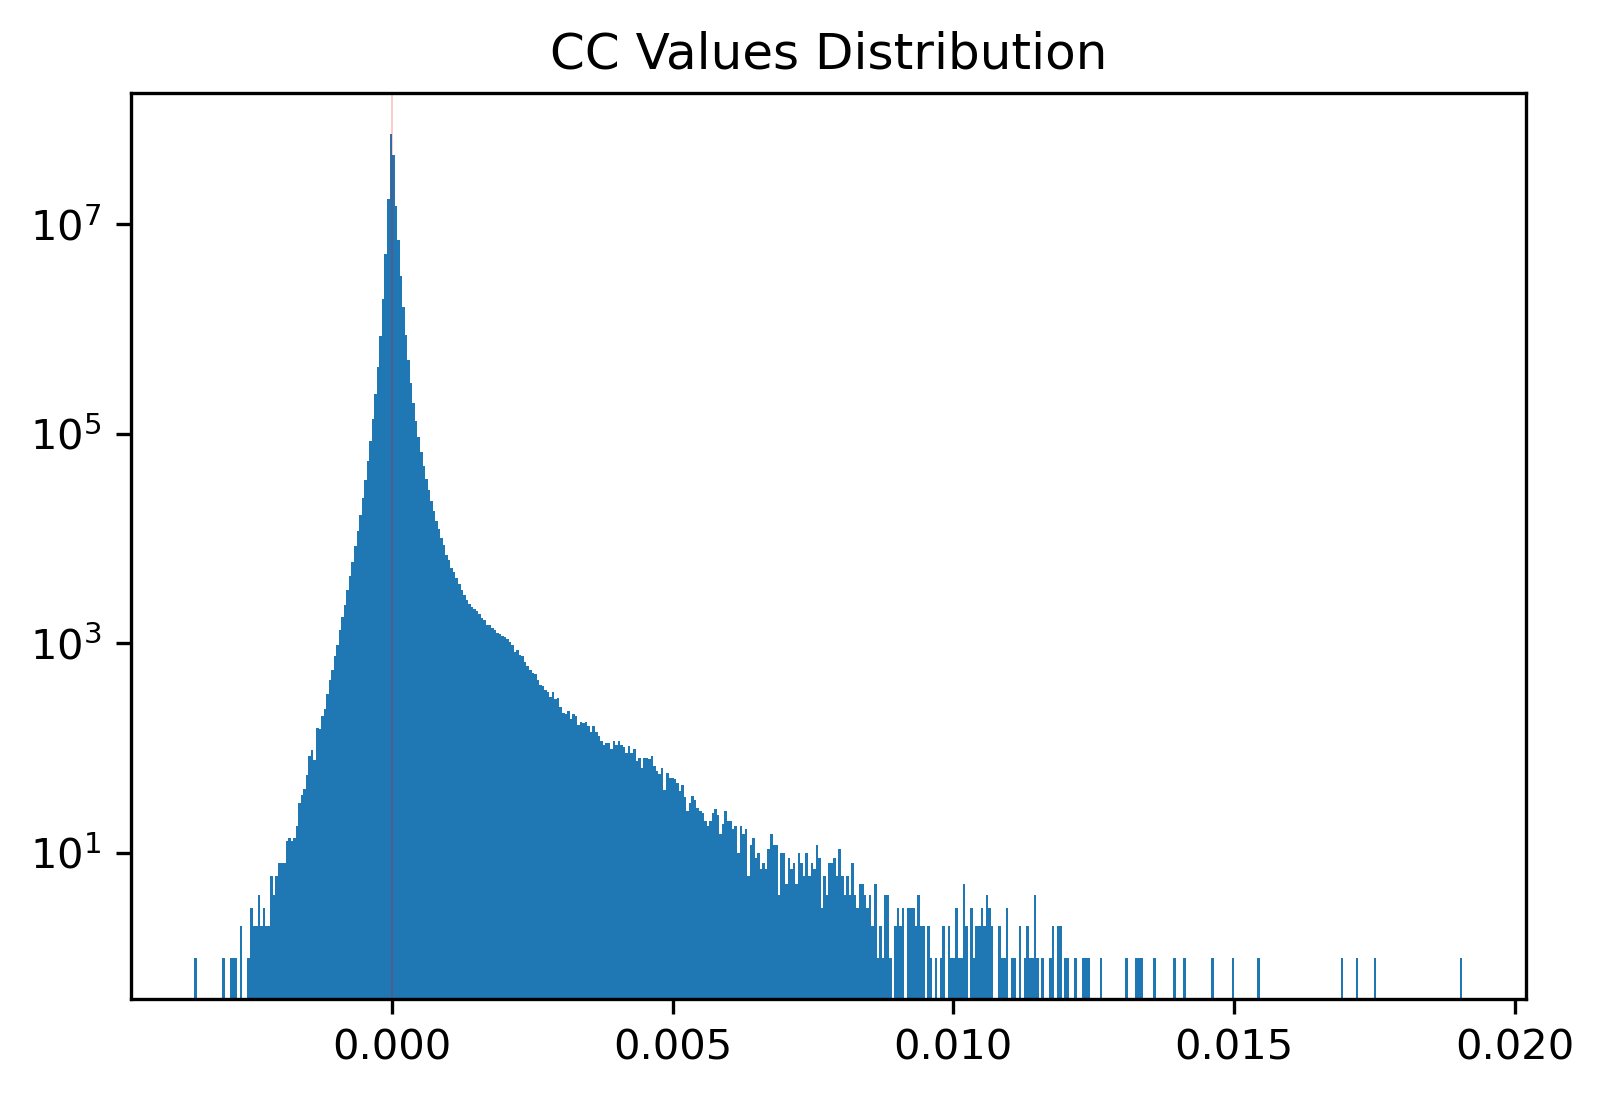

In [10]:
from matplotlib import pyplot as plt 

a = CC[np.where(CC > -3.0)].flatten()
plt.figure(dpi=300)
plt.hist(a, bins=500, log=True)
plt.title("CC Values Distribution") 
plt.axvline(x=0.0, label='0', c='r', linewidth=0.1)
plt.savefig(path + "CC.png")
plt.show()
